# Bandit simulations - with no context

Here we test various bandit models where we assume the reward distribution are not a function of a context vector.

In [1]:
import bandits

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_17171/2675420463.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Simulation setup

We simulate within batches of a fixed size.
Within each batch we predict from a policy to select which arms to select.
We sample from those arms and record the rewards.
At the end of the batch we update the policy with the arms selected and their rewards.

We use the updated policy in the subsequent batch and repeat the process.

## Bernoulli Arms

These predict a binary reward.

We can showcase this with a policy based on Thompson Sampling where we estimate the reward distribution as a beta distribution.

Here we create 5 Bernoulli arms with a random success probability each and we setup a policy to select the best single arm:

In [2]:
n_arms = 5
arms = [bandits.BernoulliArm() for _idx in range(n_arms)]
print(arms)

policy = bandits.ThompsonSamplingBeta(n_arms=n_arms, top_k=1)
print(policy)


[Bernoulli(0.549), Bernoulli(0.715), Bernoulli(0.603), Bernoulli(0.545), Bernoulli(0.424)]
Beta([1 1 1 1 1], [1 1 1 1 1])


We next simulate 2 batches and in each we simulate 10 arm selection rounds.
So that's 20 rounds in total with 4 updates to the beta distributions.

The policy keeps track of the successes and failures.

In [3]:
simulation_results = bandits.simulate_batches(
    policy=policy, arms=arms, n_batches=2, batch_size=10
)
display(policy)


100%|██████████| 2/2 [00:00<00:00, 194.42it/s]


Beta([3 3 5 3 1], [4 2 2 3 4])

The updated beta distributions can be plotted as follows.
We observe that the posterior beta distributions start to converge towards the true Bernoulli arm success probabilities.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_17171/2335856855.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


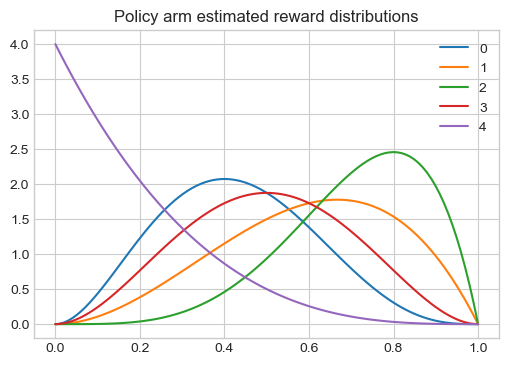

In [4]:
fig = policy.plot_pdf()
fig.axes[0].set_title("Policy arm estimated reward distributions")
fig.show()


Simulating a further 20 batches shows how the distributions improve with time.

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 166.97it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_17171/2150607722.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


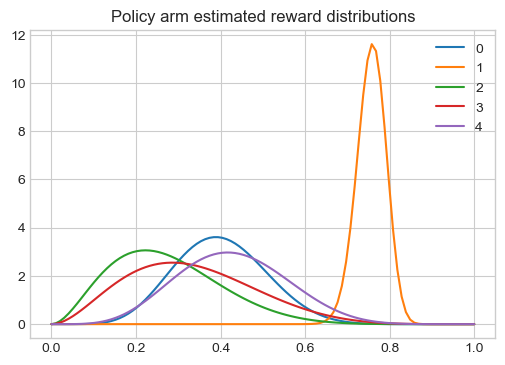

In [5]:
policy = bandits.ThompsonSamplingBeta(n_arms=n_arms, top_k=1)

policy_params = {}
simulation_results = bandits.simulate_batches(
    policy=policy,
    arms=arms,
    n_batches=20,
    batch_size=10,
    batch_callback=lambda policy, n: bandits.log_policy_quantiles(
        policy, n, policy_params
    ),
)
fig = policy.plot_pdf()
fig.axes[0].set_title("Policy arm estimated reward distributions")
fig.show()


The better performing arms are selected more frequently which is why they appear more precise than the lower performing arms.

We can show the cumulative count of arms selected over time. The slope suggests how frequently the arm is being selected. We see at the beginning the selection is more random and at the end we are selecting fewer arms.

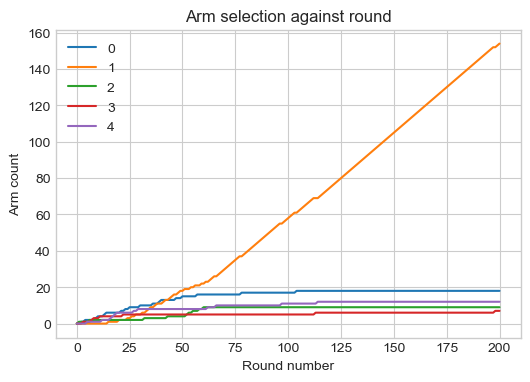

In [6]:
ax = bandits.plot_arm_selection(selected_arms=simulation_results.selected_arms)


We can plot the estimated reward distribution against round. After the first few batches the distributions start to converge. We see the most select arms have a tighter distribution compared with the less selected arms.

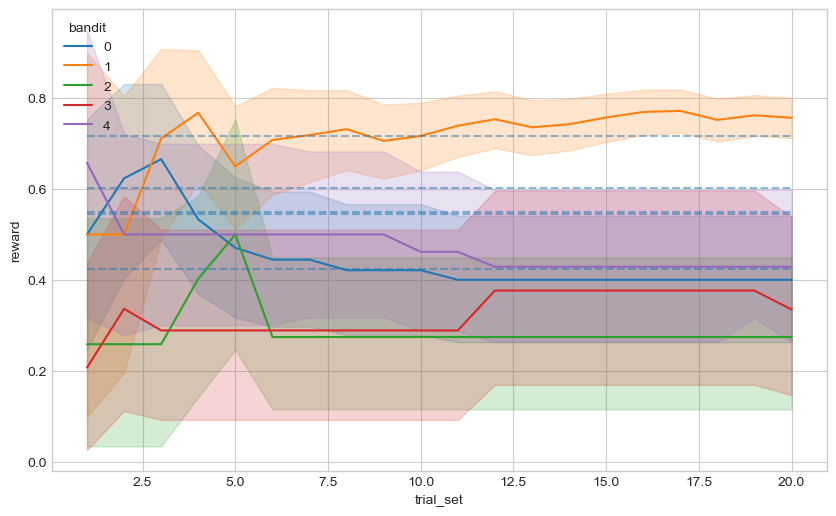

In [7]:
ax = bandits.plot_bandit_quantiles(
    bandit_quantiles={
        _idx: _policy_params["quantiles"]
        for _idx, _policy_params in policy_params.items()
    },
    arms_expected_reward=[_arm.expected_reward() for _arm in arms],
)


If we specify arms with different success probabilities we can see the selection problem more clearly.
Here we simulate 200 batches to show how the distributions converge.
The bandit selects the more performant arms as it gets a better reward distribution estimate over time.

[Bernoulli(0.050), Bernoulli(0.200), Bernoulli(0.300), Bernoulli(0.500), Bernoulli(0.600)]
Beta([1 1 1 1 1], [1 1 1 1 1])


100%|██████████| 200/200 [00:01<00:00, 196.68it/s]


Beta([   1    2   14   43 1090], [  9   9  26  54 762])

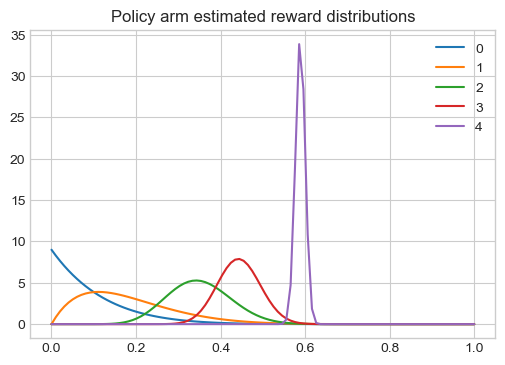

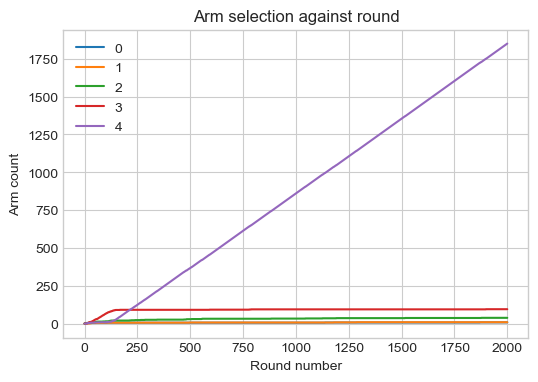

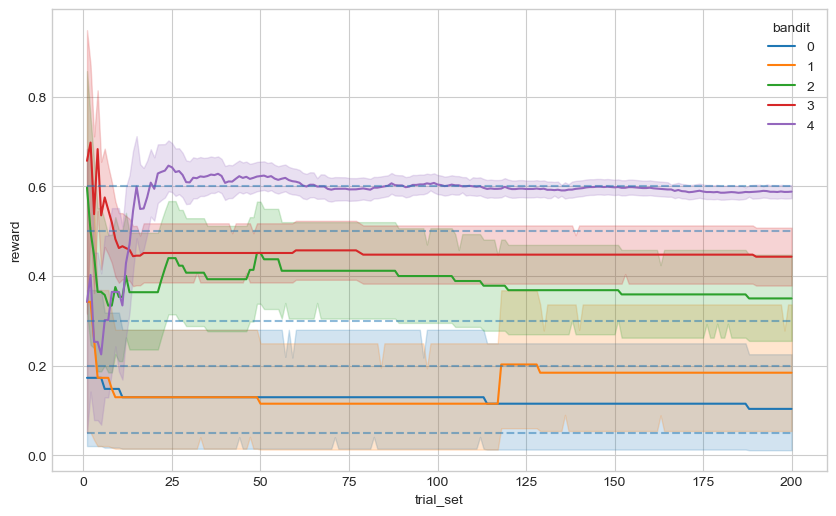

In [8]:
n_arms = 5
arms = [bandits.BernoulliArm(p=_p) for _p in [0.05, 0.2, 0.3, 0.5, 0.6]]
print(arms)

policy = bandits.ThompsonSamplingBeta(n_arms=n_arms, top_k=1)
print(policy)

policy_params = {}
simulation_results = bandits.simulate_batches(
    policy=policy,
    arms=arms,
    n_batches=200,
    batch_size=10,
    batch_callback=lambda policy, n: bandits.log_policy_quantiles(
        policy, n, policy_params
    ),
)
display(policy)

fig = policy.plot_pdf()
fig.axes[0].set_title("Policy arm estimated reward distributions")

ax = bandits.plot_arm_selection(selected_arms=simulation_results.selected_arms)

ax = bandits.plot_bandit_quantiles(
    bandit_quantiles={
        _idx: _policy_params["quantiles"]
        for _idx, _policy_params in policy_params.items()
    },
    arms_expected_reward=[_arm.expected_reward() for _arm in arms],
)


## Gaussian arms and policy

We can also simulate from Gaussian based arms.
In this case we can use Thompson Sampling where we estimate the reward distribution with a Gaussian.

[Gaussian(-1.226,6.441), Gaussian(-4.325,9.915), Gaussian(5.358,1.244), Gaussian(3.538,7.150), Gaussian(5.662,1.512)]
Gaussian([0. 0. 0. 0. 0.], [10. 10. 10. 10. 10.])


  0%|          | 0/20 [00:00<?, ?it/s]/Users/stantoon/miniconda3/envs/project_env/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/stantoon/miniconda3/envs/project_env/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
100%|██████████| 20/20 [16:05<00:00, 48.30s/it]  


Gaussian([-0.70412474  0.14955397  5.21188836  3.34353492  5.45570741], [5.42936784 0.         1.06273355 6.69143192 1.50445835])

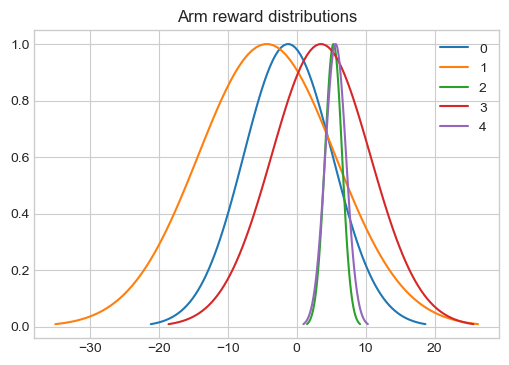

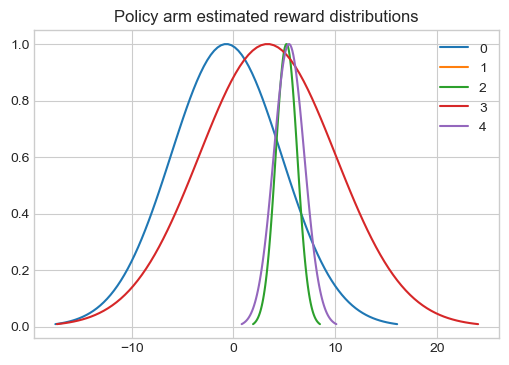

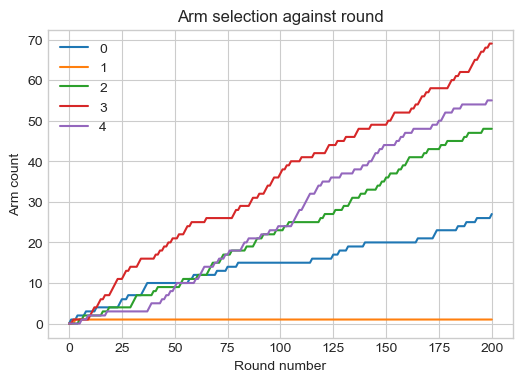

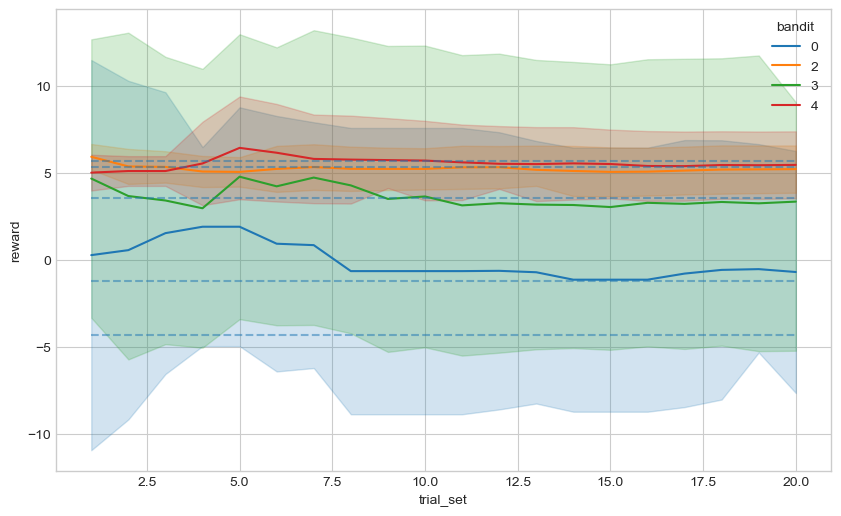

In [14]:
n_arms = 5
arms = [bandits.GaussianArm() for _idx in range(n_arms)]
print(arms)

fig, ax = plt.subplots(figsize=(6, 4))
[_arm.plot_pdf(ax=ax, label=_idx) for _idx, _arm in enumerate(arms)]
ax.set_title("Arm reward distributions")
ax.legend()

policy = bandits.ThompsonSamplingGaussian(n_arms=n_arms, top_k=1)
print(policy)

policy_params = {}
simulation_results = bandits.simulate_batches(
    policy=policy,
    arms=arms,
    n_batches=20,
    batch_size=10,
    batch_callback=lambda policy, n: bandits.log_policy_quantiles(
        policy, n, policy_params
    ),
)
display(policy)

fig = policy.plot_pdf()
fig.axes[0].set_title("Policy arm estimated reward distributions")

ax = bandits.plot_arm_selection(selected_arms=simulation_results.selected_arms)

ax = bandits.plot_bandit_quantiles(
    bandit_quantiles={
        _idx: _policy_params["quantiles"]
        for _idx, _policy_params in policy_params.items()
    },
    arms_expected_reward=[_arm.expected_reward() for _arm in arms],
)


## Top-k
We can also request the top-k arms to be selected each round rather than just the top one.
This is useful for use cases where we are selected multiple items.

[Gaussian(6.401,2.798), Gaussian(-0.831,4.057), Gaussian(4.386,1.798), Gaussian(-4.659,5.994), Gaussian(3.492,9.194), Gaussian(6.950,1.305), Gaussian(2.881,7.358), Gaussian(-4.369,8.324), Gaussian(-0.842,6.065), Gaussian(-3.861,2.420)]
Gaussian([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.])


100%|██████████| 4/4 [00:00<00:00, 188.96it/s]


Gaussian([ 5.65166751 -2.55600975  3.18021666 -3.18649595  1.97322887  7.3420085
  3.41100581 -5.40271057  2.6849445  -4.77259593], [3.27590152 3.80385746 1.66107253 6.17447282 1.53074885 1.22215624
 5.53634278 0.78988747 3.15191142 2.38742012])

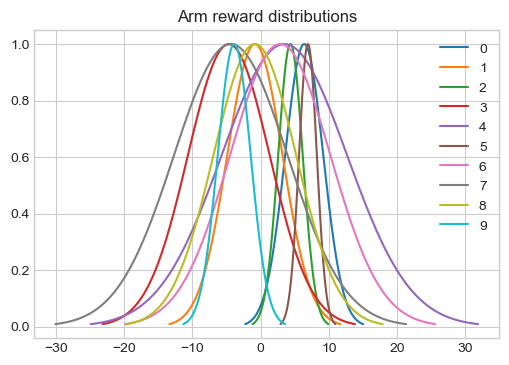

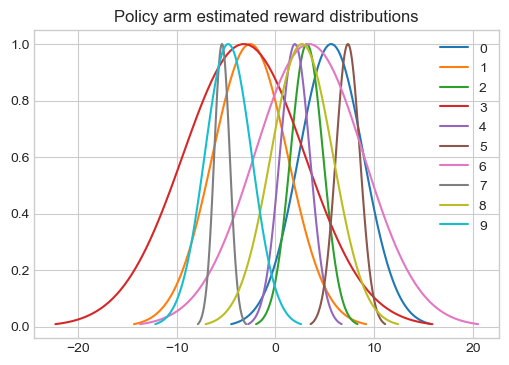

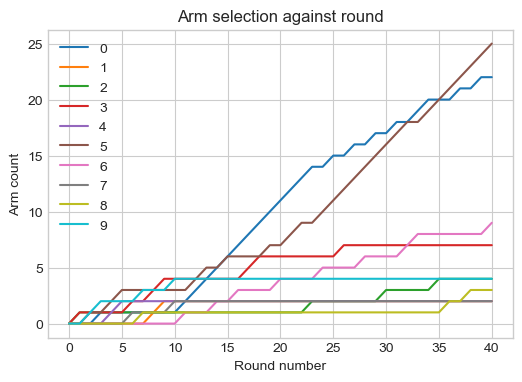

In [10]:
n_arms = 10
arms = [bandits.GaussianArm() for _idx in range(n_arms)]
print(arms)

fig, ax = plt.subplots(figsize=(6, 4))
[_arm.plot_pdf(ax=ax, label=_idx) for _idx, _arm in enumerate(arms)]
ax.set_title("Arm reward distributions")
ax.legend()

policy = bandits.ThompsonSamplingGaussian(n_arms=n_arms, top_k=2)
print(policy)

simulation_results = bandits.simulate_batches(
    policy=policy, arms=arms, n_batches=4, batch_size=10
)
display(policy)

fig = policy.plot_pdf()
fig.axes[0].set_title("Policy arm estimated reward distributions")

ax = bandits.plot_arm_selection(selected_arms=simulation_results.selected_arms)


We see that the arm count will show multiple arms being selected and we converge well towards the top-k reward distributions.

## Comparing different policies

We can use the same arms with different policies to compare.

Here we compare Thompson Sampling, UCB and random selection policies on a set of Bernoulli arms.

We see that Thompson Sampling and UCB converge to select only a couple arms.

Random selection continues to select all arms, which is similar to multi factorial testing.
In these cases we will continue to select poor performing arms.

We can calculate the cumulative reward from each policy.
The policy that selects the arm with the highest expected reward will perform the best.
The random selection policy gives a baseline which we need to beat.

We see that Thompson Sampling and UCB perform better than random, suggesting they are learning the arm reward distributions.

[Bernoulli(0.980), Bernoulli(0.063), Bernoulli(0.339), Bernoulli(0.330), Bernoulli(0.193), Bernoulli(0.068), Bernoulli(0.701), Bernoulli(0.310), Bernoulli(0.927), Bernoulli(0.779)]


100%|██████████| 100/100 [00:00<00:00, 1480.19it/s]
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_17171/1684274267.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_sel.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_17171/1684274267.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_rew.show()


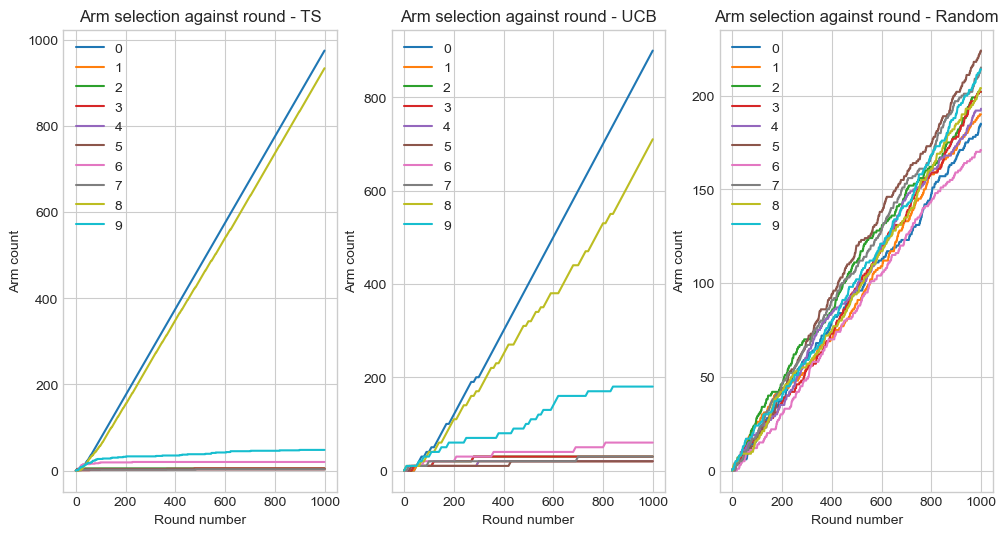

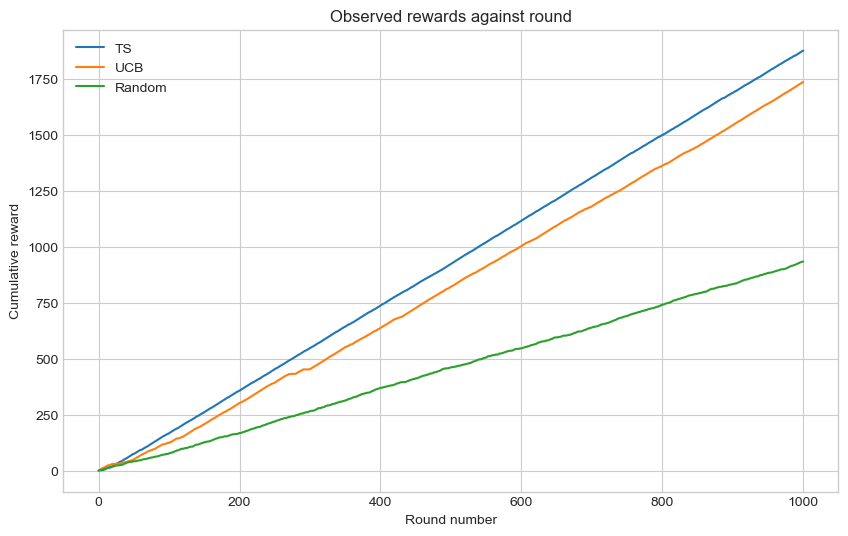

In [11]:
# create many arms
n_arms = 10
arms = [bandits.BernoulliArm() for _idx in range(n_arms)]
print(arms)

# create multiple policies
policies = {
    "TS": bandits.ThompsonSamplingBeta(n_arms=n_arms, top_k=2),
    "UCB": bandits.UCB(n_arms=n_arms, top_k=2),
    "Random": bandits.RandomPolicy(n_arms=n_arms, top_k=2),
}

simulation_results = {
    _name: bandits.simulate_batches(
        policy=_policy, arms=arms, n_batches=100, batch_size=10
    )
    for _name, _policy in policies.items()
}

fig_sel, ax_sel = plt.subplots(figsize=(12, 6), ncols=len(simulation_results))
fig_rew, ax_rew = plt.subplots(figsize=(10, 6))
for _idx, (_name, _simulation_results) in enumerate(simulation_results.items()):
    bandits.plot_arm_selection(
        selected_arms=_simulation_results.selected_arms, ax=ax_sel[_idx]
    )
    ax_sel[_idx].set_title(ax_sel[_idx].get_title() + " - " + _name)
    bandits.plot_rewards(rewards=_simulation_results.rewards, ax=ax_rew, label=_name)
ax_rew.legend()

fig_sel.show()
fig_rew.show()
